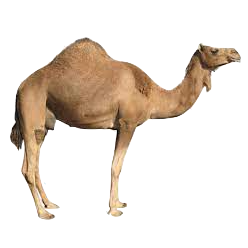

In [1]:
from IPython.display import Image as Image_colab
from IPython.display import display
from PIL import Image
import os

def mInput(prompt, default=None):
    prompt = f"{prompt} [{default}]: " if default else f"{prompt}: "
    response = input(prompt)
    return response if response else default

target_image = mInput("Image name:",default="camel.png")
abs_path = os.path.abspath(os.getcwd())
target_ = f"{abs_path}/target_images/{target_image}"
img_ = Image_colab(target_)
display(img_)

Processing [camel.png] ...


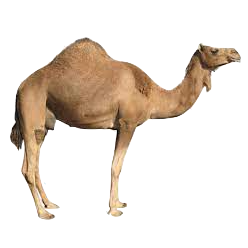

GPU: True, 0


In [2]:
import torch
gpunum=0

os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([f"{gpunum}"])
print("=" * 50)
print(f"Processing [{target_image}] ...")
img_ = Image_colab(target_)
display(img_)
print(f"GPU: {torch.cuda.is_available()}, {torch.cuda.current_device()}")
print("=" * 50)

In [3]:
seeds = 1001

from painterly_rendering import *

sys.argv = ['painterly_rendering.py', 'D:\\code\\CLIPasso/target_images/camel.png', '--num_paths', '16', '--output_dir', 'D:\\code\\CLIPasso/output_sketches/camel/', '--wandb_name', 'camel_16strokes_seed0', '--num_iter', '2001', '--save_interval', '10', '--seed', '0', '--use_gpu', '1', '--fix_scale', '0', '--mask_object', '0', '--mask_object_attention', '0', '--display_logs', '0', '--display', '0']

args = config.parse_arguments()
final_config = vars(args)

loss_func = Loss(args)
inputs, mask = get_target(args)

utils.log_input(args.use_wandb, 0, inputs, args.output_dir)
renderer = load_renderer(args, inputs, mask)

optimizer = PainterOptimizer(args, renderer)
counter = 0
configs_to_save = {"loss_eval": []}
best_loss, best_fc_loss = 100, 100
best_iter, best_iter_fc = 0, 0
min_delta = 1e-5
terminate = False

renderer.set_random_noise(0)
img = renderer.init_image(stage=0)





In [5]:
print(renderer.control_points_set[0])

tensor([[126.0000,  83.0000],
        [129.8575,  85.8891],
        [128.9679,  83.1890],
        [129.0942,  82.1242]], device='cuda:0')


cos_sim: 0.7633560299873352, att_sim: 0.06355690956115723
cos_sim: 0.4949248731136322, att_sim: 0.043575167655944824
cos_sim: 0.6847156882286072, att_sim: 0.08113157749176025
cos_sim: 0.041157323867082596, att_sim: 0.030695080757141113
cos_sim: -0.5090582370758057, att_sim: 0.1064099669456482
cos_sim: 0.6803855895996094, att_sim: 0.011315107345581055
cos_sim: -0.24115602672100067, att_sim: 0.19572687149047852
cos_sim: 0.807856559753418, att_sim: 0.4163106083869934
cos_sim: 0.9833319187164307, att_sim: 0.057297706604003906
cos_sim: 0.18147963285446167, att_sim: 0.02371346950531006
cos_sim: 0.08560910075902939, att_sim: 0.2775805592536926
cos_sim: -0.21825236082077026, att_sim: 0.01613008975982666
cos_sim: -0.22504861652851105, att_sim: 0.21823662519454956
cos_sim: 0.12500251829624176, att_sim: 0.03442668914794922
cos_sim: 0.9229701161384583, att_sim: 0.07776099443435669
cos_sim: 0.7633560299873352, att_sim: 0.06355690956115723
cos_sim: 0.5980851650238037, att_sim: 0.10713207721710205
co

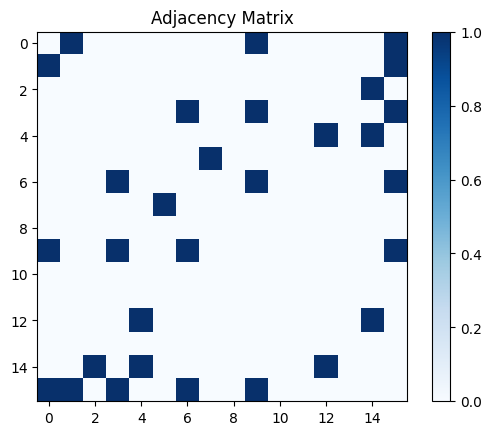

In [ ]:
import torch
import matplotlib.pyplot as plt

#learnable parameters
similar_threshold = 0.7
attention_threshold = 0.2


def computeCosineSimilarity(pointA: torch.Tensor, pointB: torch.Tensor):
    # 计算两个向量的余弦相似度
    dot_product = torch.dot(pointA, pointB)
    normA = torch.norm(pointA)
    normB = torch.norm(pointB)
    return dot_product / (normA * normB + 1e-8)

def computePointsCosineSimilarity(pointsA: torch.Tensor, pointsB: torch.Tensor):
    assert len(pointsA) == len(pointsB)
    n = len(pointsA)
    
    # 对集合进行排序，按照第一维
    pointsA = pointsA[pointsA[:, 0].argsort()]
    pointsB = pointsB[pointsB[:, 0].argsort()]

    # 差分
    diffA = pointsA[1:] - pointsA[:-1]
    diffB = pointsB[1:] - pointsB[:-1]

    # 计算余弦相似度
    cosine_sim = torch.tensor([computeCosineSimilarity(diffA[i], diffB[i]) for i in range(n-1)])

    return cosine_sim.mean()

def getAttention(point: torch.Tensor):
    return renderer.attention_map[point[1].long(), point[0].long()]

def computeAttentionSimilarity(pointsA: torch.Tensor, pointsB: torch.Tensor):
    assert len(pointsA) == len(pointsB)
    n = len(pointsA)
    
    attention_A = torch.tensor([getAttention(point) for point in pointsA])
    attention_B = torch.tensor([getAttention(point) for point in pointsB])

    return abs(attention_A.mean() - attention_B.mean())

def computeAdjacencyMatrix(points_set):
    num_points = len(points_set)
    adjacency_matrix = torch.zeros((num_points, num_points), dtype=torch.float32)
    for i in range(len(points_set)):
        for j in range(len(points_set)):
            if i == j:
                continue
            cos_sim = computePointsCosineSimilarity(points_set[i], points_set[j])
            att_sim = computeAttentionSimilarity(points_set[i], points_set[j])
            print(f"cos_sim: {cos_sim}, att_sim: {att_sim}")
            adjacency_matrix[i, j] = torch.where(cos_sim > similar_threshold and att_sim < attention_threshold, torch.tensor(1.0), torch.tensor(0.0))
    return adjacency_matrix

adjacency_matrix = computeAdjacencyMatrix(renderer.control_points_set)

plt.imshow(adjacency_matrix.cpu().numpy(), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Adjacency Matrix')
plt.show()

feature_matrix = torch.tensor(renderer.control_points_set)


In [ ]:
import pydiffvg
import matplotlib.pyplot as plt
canvas_width, canvas_height = renderer.attention_map.shape[0],renderer.attention_map.shape[1]
pydiffvg.set_use_gpu(torch.cuda.is_available())
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, renderer.shapes, renderer.shape_groups)
render = pydiffvg.RenderFunction.apply
out = render(canvas_width, # width
             canvas_height, # height
             2,   # num_samples_x
             2,   # num_samples_y
             0,   # seed
             None,
             *scene_args)

plt.figure()

atm = renderer.attention_map
atm_tensor = torch.tensor(atm, device='cuda', dtype=torch.float32)
# 访问 out 的每个像素
print(out.shape)
# 输出 (224,224,1)的值
print(out[:,:,3])

out[:, :, 3] = torch.where(out[:, :, 3] > 0, atm_tensor, out[:, :, 3])

plt.imshow(out[:,:,3].cpu(),cmap='viridis')




In [ ]:
import matplotlib.pyplot as plt

plt.imshow(renderer.attention_map,cmap='viridis')
plt.colorbar()
plt.show()
print(renderer.attention_map)